In [1]:
import numpy as np
from scipy.io import loadmat
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy.signal import *
from math import sqrt

In [2]:
sintesis = loadmat('sintesis.mat')
sintesis

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 09 12:18:20 2020',
 '__version__': '1.0',
 '__globals__': [],
 'coef': array([[ 1.        , -0.40321523, -0.10422101, ...,  0.00110615,
         -0.13328689,  0.09413874],
        [ 1.        , -0.40364892,  0.00571017, ..., -0.11009042,
         -0.23399183,  0.15338591],
        [ 1.        , -0.30258198, -0.04449645, ..., -0.11747033,
         -0.13732837,  0.12694894],
        ...,
        [ 1.        , -0.48897606, -0.2780322 , ...,  0.02094446,
         -0.14134451,  0.17131546],
        [ 1.        , -0.51040743, -0.16454425, ...,  0.03291948,
          0.07583863, -0.03061901],
        [ 1.        , -0.37012351, -0.29168727, ...,  0.03491205,
          0.05917975,  0.00574997]]),
 'excit': array([[ 0.23452913, -1.21976728,  0.07965829, ..., -2.13809009,
         -1.20137136, -0.84286915],
        [-1.36262477,  0.74873396,  0.47875199, ...,  0.46577369,
          0.09968263,  0.58093255],
        [ 0.0

**Part A**

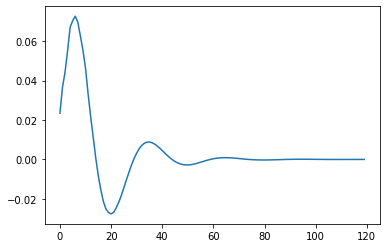

In [3]:
#a
a, b = sintesis['coef'], sintesis['ganancia'][0]
x = np.zeros(120)
x[0] = 1

plt.plot(lfilter([b[100]], a[100], x))

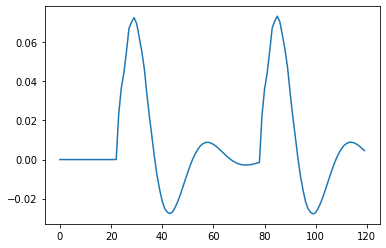

In [4]:
#b
a, b = sintesis['coef'], sintesis['ganancia'][0]
x = sintesis['excit'][100]

# 120 muestras, 15ms todas las muestras.
plt.plot(lfilter([b[100]], a[100], x))

Tenim 4927 0s!!


([<matplotlib.lines.Line2D at 0x7fd7fa11f2e8>],
 array([ 6.70209597e-05, -3.21546787e-04, -9.99037653e-05, ...,
         8.28647779e-04,  7.08913931e-04,  9.03244615e-04]))

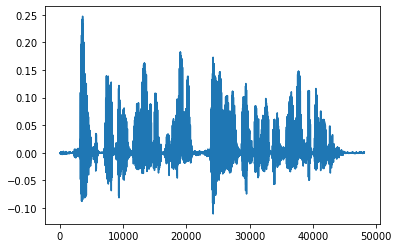

In [5]:
#c
y = []
x = sintesis['excit']
a = sintesis['coef']
b = sintesis['ganancia'][0]
longitud = len(a)
for i in range(longitud):
    y = np.concatenate((y, lfilter([b[i]], a[i], x[i])), axis=None)
#d
comptador = 0
for i in range(len(y)):
    if y[i] == 0:
        comptador += 1
        
print('Tenim', comptador,'0s!!')    
scipy.io.wavfile.write('vocoder1.wav', 8000, y)
plt.plot(y), y

Tenim 0 0s!!


([<matplotlib.lines.Line2D at 0x7fd7f9f08fd0>],
 array([ 0.00027064, -0.00129844, -0.00040342, ...,  0.00321958,
         0.00273633,  0.0035213 ]))

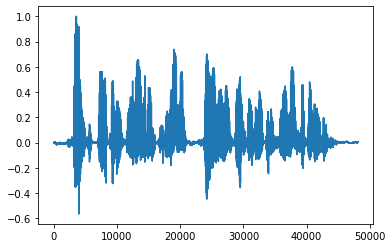

In [6]:
#e
y = []
x = sintesis['excit']
a = sintesis['coef']
b = sintesis['ganancia'][0]
longitud = len(a)
zf = np.zeros(10)
for i in range(longitud):
    filtro, zf = lfilter([b[i]], a[i], x[i], axis= -1, zi=zf)
    y = np.append(y, filtro)

y_max = max(abs(y))
y /= y_max

comptador = 0
for i in range(len(y)):
    if y[i] == 0:
        comptador += 1
        
print('Tenim', comptador,'0s!!') 

scipy.io.wavfile.write('vocoder2.wav', 8000, y)
plt.plot(y), y

**Part B**

Demostració apartat A

<img src="A.jpg">

Demostració apartat B

<img src="B.jpg">

<img src="C.jpg" class="rotate90">

In [7]:
#c
def calc_periodes():
    periodes = []
    for trama in range(401):
        a, b = sintesis['coef'], sintesis['ganancia'][0]
        x = sintesis['excit'][trama]
        y = lfilter([b[trama]], a[trama], x)
        Ryy = convolve(y, y[::-1])
        Ryy = list(Ryy)
        pos_Ryy0 = np.argmax(Ryy)
        Ryy0 = Ryy[pos_Ryy0]
        peaks = []
        for i in range(pos_Ryy0+5, len(Ryy)-1):
            prev = Ryy[i-1]
            curr = Ryy[i]
            nxt = Ryy[i+1]
            if prev < curr and curr > nxt:
                peaks.append([i, curr])
        if len(peaks) >= 2:
            peaks.sort(reverse=True, key=lambda x : x[1])
            
            pos_RyyN, RyyN = peaks[1]
            N = abs(pos_Ryy0 - pos_RyyN)
            periodes.append((N, RyyN/Ryy0 < 0.7)) #True si sord!!
        else:
            periodes.append((None, True))
    return periodes

In [8]:
#d
excitacio = np.zeros([401,120])
dif = 0
periodes = calc_periodes()
for i in range(401):
    if not periodes[i][1]:
        Ni = periodes[i][0]
        if dif != 0:
            inicio = Ni - dif
        else:
            inicio = 0
        while inicio < 0:
            inicio += Ni
        for j in range(inicio, 120, Ni):
            excitacio[i][j] = 1
            dif = 120 + Ni - inicio - j
    else:
        excitacio[i] = np.random.normal(loc=0, scale=1, size=120)

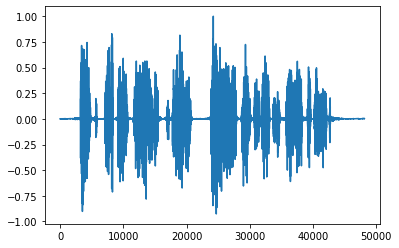

In [9]:
#e
y = []
x = excitacio
a = sintesis['coef']
b = sintesis['ganancia'][0]
longitud = len(a)
zf = np.zeros(10)
for i in range(longitud):
    filtro, zf = lfilter([b[i]], a[i], x[i], axis= -1, zi=zf)
    y = np.append(y, filtro)

y_max = max(abs(y))
y /= y_max
scipy.io.wavfile.write('vocoder_personalitzat.wav', 8000, y)
plt.plot(y)